<a href="https://colab.research.google.com/github/gcassella/NN-VMC/blob/main/helium_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import jax.numpy as np
import jax
from jax import random, grad, jacfwd, jacrev, vmap, jit, pmap
from jax.ops import index_add, index_update
from functools import partial
from scipy.linalg import solve

key = random.PRNGKey(0)
key, subkey = random.split(key)

# Stochastic reconfiguration w/ Hylleraas wavefunction

In [4]:
@jit
def hirschfelder(x, p):
    r = np.linalg.norm(x, axis=1)
    r1 = r[0]
    r2 = r[1]

    s = r1 + r2
    t = r1 - r2
    u = np.linalg.norm(np.subtract(x[1], x[0]))

    return np.exp(-2*s)*(1 + 0.5*u*np.exp(-p[0]*u))*(1 + p[1]*s*u + p[2]*np.power(t, 2) + p[3]*np.power(u, 2))

@jit
def simple(x, p):
    r = np.linalg.norm(x, axis=1)
    r1 = r[0]
    r2 = r[1]

    return np.exp(-p[0]*(r1 + r2))

def hess(f): 
    return jacfwd(jacrev(f, 0), 0)

@partial(jit, static_argnums=(0,))
def lapl_evalat(f, x):
    """
    Evaluates (\nabla^2 f)(x) by taking the trace of the Hessian matrix of f
    """
    H = hess(f)(x).reshape(x.shape[0]*x.shape[1], x.shape[0]*x.shape[1])
    return np.trace(H)

In [5]:
@partial(jit, static_argnums=(1,))
def config_step(key, pdf, config, config_prob, config_idx, step_size):
    key, subkey = random.split(key)
    move_proposal = random.normal(key, shape=(config.shape[1],))*step_size
    proposal = index_add(config, config_idx%config.shape[0], move_proposal)
    proposal_prob = pdf(proposal)

    uniform = random.uniform(subkey)
    accept = uniform < (proposal_prob / config_prob)

    new_config = np.where(accept, proposal, config)
    config_prob = np.where(accept, proposal_prob, config_prob)
    return new_config, config_prob, config_idx+1

@partial(jit, static_argnums=(1, 2, 3, 4))
def get_configs(key, pdf, n_iter, n_equi, step_size, initial_config):
    """
    Carries out Metropolis-Hastings sampling according to the distribution |`wf`|**2.0.
    
    Performs `n_equi` equilibriation steps and `n_iter` sampling steps.
    """
    
    def mh_update(i, state):
      key, config, prob, idx = state
      _, key = random.split(key)
      new_config, new_prob, new_idx = config_step(
          key,
          pdf,
          config,
          prob,
          idx,
          step_size
      )
      return (key, new_config, new_prob, new_idx)

    def mh_update_and_store(i, state):
      key, config, prob, idx, configs = state
      _, key = random.split(key)
      new_config, new_prob, new_idx = config_step(
          key,
          pdf,
          config,
          prob,
          idx,
          step_size
      )
      new_configs = index_update(configs, idx, new_config)
      return (key, new_config, new_prob, new_idx, new_configs)

    prob = pdf(initial_config)
    key, config, prob, idx = jax.lax.fori_loop(0, n_equi, mh_update, (key, initial_config, prob, 0))
    init_configs = np.zeros((n_iter, *initial_config.shape))
    key, config, prob, idx, configs = jax.lax.fori_loop(0, n_iter, mh_update_and_store, (key, config, prob, 0, init_configs))

    return configs

In [6]:
@partial(jit, static_argnums=(1,2,))
def itime_hamiltonian(config, wf, p, tau=0.1):
    n_electron = config.shape[0]
    curr_wf = wf(config, p)
    acc = 0
    # Calculate kinetic energy
    acc += -0.5*(1/curr_wf)*lapl_evalat(lambda x: wf(x, p), config)
    # Calculate electron-electron energy
    for i in range(n_electron):
        for j in range(n_electron):
            if i < j:
                acc += 1 / np.linalg.norm(np.subtract(config[i], config[j]))

    # Calculate electron-nucleus energy, assume z=ne FOR NOW
    for i in range(n_electron):
        acc -= n_electron / np.linalg.norm(config[i])
    # Forget about nucleus - nucleus energy FOR NOW

    return 1-tau*acc

@partial(jit, static_argnums=(1,2,))
def sr_op(config, wf, p):
    gradlog = np.concatenate((np.array([1]), np.array(grad(lambda x, p: np.log(wf(x, p)), 1)(config, p))))
    ih = itime_hamiltonian(config, wf, p)
    
    return np.multiply(gradlog, ih)

@partial(jit, static_argnums=(1,2,))
def overlap_matrix(config, wf, p):
    """
    Find the overlap matrix on the space of the parametric derivatives of `wf`
    """
    
    gradlog = np.concatenate((np.array([1]), np.array(grad(lambda x, p: np.log(wf(x, p)), 1)(config, p))))
    overlap_ij = lambda i, j: gradlog[i]*gradlog[j]
    
    grid = np.indices((gradlog.shape[0], gradlog.shape[0]))
    
    return overlap_ij(grid[0], grid[1])

@partial(jit, static_argnums=(1,2,))
def local_energy(config, wf, p):
    """
    Local energy operator. Uses JAX autograd to obtain laplacian for KE.
    """

    n_electron = config.shape[0]
    acc = 0
    # Calculate kinetic energy
    acc += -0.5*(1/wf(config, p))*lapl_evalat(lambda x: wf(x, p), config)
    # Calculate electron-electron energy
    for i in range(n_electron):
        for j in range(n_electron):
            if i < j:
                acc += 1 / np.linalg.norm(np.subtract(config[i], config[j]))

    # Calculate electron-nucleus energy, assume z=ne FOR NOW
    for i in range(n_electron):
        acc -= n_electron / np.linalg.norm(config[i])

    return acc

In [7]:
@partial(jit, static_argnums=(0, 1, 2))
def monte_carlo(op, wf, p, configs):
    """
    Performs a Monte Carlo integration using the `configs` walker positions
    of the expectation value of `op` for the wavefunction `wf`.
    
    Returns the expectation value, variance and a list of the sampled values {O_i}
    """

    samp_rate = 1000
    walker_values = vmap(lambda config: op(config, wf, p))(configs)
    op_output_shape = walker_values[0].shape
    num_blocks = (walker_values.shape[0]//samp_rate)
    blocks = walker_values[:samp_rate*(num_blocks)].reshape((num_blocks, samp_rate, *op_output_shape))
    k = blocks.shape[0]
    block_means = np.mean(blocks, axis=1)
    op_expec = np.mean(block_means, axis=0)
    op_var = 1/(k*(k-1))*np.sum(np.power(block_means - op_expec, 2), axis=0)
    return op_expec, op_var

In [8]:
run_mcmc = vmap(get_configs, in_axes=(0, None, None, None, None, 0), out_axes=0)
run_int = vmap(monte_carlo, in_axes=(None, None, None, 0), out_axes=0)

def reduce_mc_outs(outs):
  mean = np.mean(outs[0], axis=0)
  variance = 1/(outs[0].shape[0]*(outs[0].shape[0]-1))*np.sum(outs[1] + np.power(outs[0] - mean, 2), axis=0)
  return mean, variance

In [ ]:
n_equi = 10000
n_iter = 100000
n_chains = 500
p0 = [1.6875]
xis = random.uniform(key, (n_chains, 2, 3))
keys = random.split(key, n_chains)
sample_dens = jit(lambda x: np.power(np.abs(simple(x, p0)), 2))
configs = run_mcmc(keys, sample_dens, n_iter, n_equi, 0.5, xis)

E_E, E_V = reduce_mc_outs(run_int(local_energy, simple, p0, configs))
overlap_E, overlap_V = reduce_mc_outs(run_int(overlap_matrix, simple, p0, configs))
sr_E, sr_V = reduce_mc_outs(run_int(sr_op, simple, p0, configs))

In [9]:
E_V

DeviceArray(5.033878e-07, dtype=float32)

## Simple WF

In [7]:
key = random.PRNGKey(0)

In [ ]:
key = random.PRNGKey(0)
n_equi = 10000
n_iter = 100000
p0 = [1.7]

key, subkey = random.split(key)

n_chains = 1
xis = random.uniform(key, (n_chains, 2, 3))
keys = random.split(key, n_chains)

In [ ]:
vals = []
errs = []

for p0 in [[x] for x in np.arange(1.0, 2.0, 0.05)]:
  print("Loop {}".format(p0))
  sample_dens = jit(lambda x: np.power(np.abs(simple(x, p0)), 2))
  configs = run_mcmc(keys, sample_dens, n_iter, n_equi, 0.5, xis).reshape(-1, 2, 3)
  E_E, E_V = monte_carlo(local_energy, simple, p0, configs)
  vals.append(E_E)
  errs.append(E_V)


<ErrorbarContainer object of 3 artists>

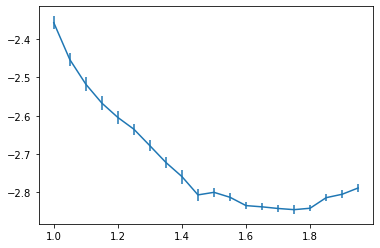

In [89]:
import matplotlib.pyplot as plt
plt.errorbar(np.arange(1.0, 2.0, 0.05), vals, yerr=np.sqrt(np.array(errs)))

In [13]:
n_equi = 10000
n_iter = 100000
n_chains = 500
xis = random.uniform(key, (n_chains, 2, 3))
keys = random.split(key, n_chains)
p0 = [2.0]
vals = [2.0]

for i in range(40):
  sample_dens = jit(lambda x: np.power(np.abs(simple(x, p0)), 2))
  configs = run_mcmc(keys, sample_dens, n_iter, n_equi, 0.5, xis)
  E_E, E_V = reduce_mc_outs(run_int(local_energy, simple, p0, configs))
  overlap_E, overlap_V = reduce_mc_outs(run_int(overlap_matrix, simple, p0, configs))
  sr_E, sr_V = reduce_mc_outs(run_int(sr_op, simple, p0, configs))

  dps = solve(overlap_E, sr_E)
  p0 = np.add(np.array(p0), dps[1:] / dps[0])
  vals.append(p0)
  print(p0)

[1.9275614]
[1.8775066]
[1.8407385]
[1.8126912]
[1.7904707]
[1.772807]
[1.7586429]
[1.747057]
[1.7374473]
[1.7294773]
[1.7229158]
[1.7174726]
[1.7128438]
[1.7088931]
[1.7057276]
[1.7028962]
[1.7006251]
[1.6985586]
[1.6969322]
[1.6955091]
[1.694281]
[1.6932894]
[1.6924859]
[1.6918188]
[1.6912352]
[1.6906124]
[1.6901096]
[1.6897206]
[1.689427]
[1.6892067]
[1.6889602]
[1.6887077]
[1.688536]
[1.6883833]
[1.6882454]
[1.6881869]
[1.688199]
[1.6881694]
[1.6881847]
[1.6881961]


In [15]:
sample_dens = jit(lambda x: np.power(np.abs(simple(x, p0)), 2))
configs = run_mcmc(keys, sample_dens, n_iter, n_equi, 0.5, xis)
E_E, E_V = reduce_mc_outs(run_int(local_energy, simple, p0, configs))
print("Ground state energy {} pm {} after 40 iterations with parameter {}".format(E_E, np.sqrt(E_V), p0))

Ground state energy -2.8477447032928467 pm 0.000718296505510807 after 40 iterations with parameter [1.6881961]


## Hirschfelder wavefunction

In [9]:
n_equi = 10000
n_iter = 100000
n_chains = 100
xis = random.uniform(key, (n_chains, 2, 3))
keys = random.split(key, n_chains)
p0 = [1.0, 0.5, 0.5, -0.1]
vals = [p0]

for i in range(40):
  sample_dens = jit(lambda x: np.power(np.abs(hirschfelder(x, p0)), 2))
  configs = run_mcmc(keys, sample_dens, n_iter, n_equi, 0.5, xis)
  E_E, E_V = reduce_mc_outs(run_int(local_energy, hirschfelder, p0, configs))
  overlap_E, overlap_V = reduce_mc_outs(run_int(overlap_matrix, hirschfelder, p0, configs))
  sr_E, sr_V = reduce_mc_outs(run_int(sr_op, hirschfelder, p0, configs))

  dps = solve(overlap_E, sr_E)
  p0 = np.add(np.array(p0), dps[1:] / dps[0])
  vals.append(p0)
  print(p0)

[ 1.4236624   0.5324303   0.44780415 -0.1185777 ]
[ 1.8274268   0.52555925  0.38857707 -0.14034285]
[ 2.1532216   0.5014799   0.34327382 -0.14871532]
[ 2.1948583   0.47658455  0.31286922 -0.14467369]
[ 2.0115626   0.4537761   0.29153362 -0.13413884]
[ 1.8770361   0.43206456  0.27365276 -0.12360602]
[ 1.7592784   0.41211852  0.2586345  -0.11351466]
[ 1.6649686   0.39407298  0.24570781 -0.10441782]
[ 1.577496    0.37777448  0.23474768 -0.09616143]
[ 1.5076677   0.3633409   0.22492754 -0.0890992 ]
[ 1.4467105   0.35067847  0.21633679 -0.08313622]
[ 1.3945475   0.33940798  0.2087992  -0.0780477 ]
[ 1.3490429   0.32962883  0.20208855 -0.07381274]
[ 1.3063763   0.3208327   0.19627199 -0.07010238]
[ 1.2701937   0.31305918  0.1910933  -0.06695889]
[ 1.2391235   0.3063077   0.18647681 -0.06442851]
[ 1.2104979   0.30031046  0.18252607 -0.06231608]
[ 1.187672    0.29506224  0.17885162 -0.06052488]
[ 1.1666455   0.29016247  0.17578799 -0.05881443]
[ 1.1456738   0.28589332  0.17293528 -0.0574354 ]


In [10]:
sample_dens = jit(lambda x: np.power(np.abs(hirschfelder(x, p0)), 2))
configs = run_mcmc(keys, sample_dens, n_iter, n_equi, 0.5, xis)
E_E, E_V = reduce_mc_outs(run_int(local_energy, hirschfelder, p0, configs))
print("Ground state energy {} pm {} after 40 iterations with parameter {}".format(E_E, np.sqrt(E_V), p0))

Ground state energy -2.901717185974121 pm 0.00027340053929947317 after 40 iterations with parameter [ 0.9998273   0.2546163   0.1520364  -0.04904639]


# Multi layer perceptron wavefunction

In [ ]:
# Code reproduced with modifications from
# https://github.com/google/jax/blob/master/docs/notebooks/neural_network_with_tfds_data.ipynb

# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=1e-2):
      w_key, b_key = random.split(key)
      return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [6, 32, 32, 32, 1]
params = init_network_params(layer_sizes, random.PRNGKey(0))

def tanh(x):
    return np.tanh(x)

def predict(x, p):
    # per-example predictions
    activations = x.flatten()
    params = p
    for w, b in params[:-1]:
        outputs = np.dot(w, activations) + b
        activations = tanh(outputs)
    
    final_w, final_b = params[-1]
    return (np.dot(final_w, activations) + final_b)[0]

In [ ]:
p0 = params

In [ ]:
%%timeit
predict(xi, p0)

12.5 ms ± 1.58 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
sample_dens(xi, predict)

DeviceArray([0.00051011], dtype=float32)

In [ ]:
e_expec, e_var, _ = monte_carlo(local_energy, predict, configs)

In [ ]:
grad(predict)(xi, p0)

DeviceArray([[-1.1215644e-06,  9.2081854e-07,  1.2777372e-06],
             [-2.7824185e-06,  8.5019434e-07,  2.5524919e-06]],            dtype=float32)

In [ ]:
predict

ValueError: All input arrays must have the same shape.

ValueError: All input arrays must have the same shape.